### Modeling excercises after Maggie's walkthrough lesson

##### Using the saas.csv 

In [25]:
#imports

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env
import acquire

In [26]:
url = 'https://ds.codeup.com/saas.csv'
df = pd.read_csv(url)
print('shape:', df.shape)
df.head()

shape: (790458, 5)


,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [28]:
df.Subscription_Type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: Subscription_Type, dtype: int64

In [29]:
df.Amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: Amount, dtype: int64

In [30]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=13)
plt.style.use('bmh')

### Data Prep

In [31]:
# Lowercase column names
df.columns = [col.lower() for col in df]
# Properly parse the datetime field
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [32]:
df.subscription_type = df.subscription_type.astype(int)

In [33]:
df.amount = df.amount.astype(int)

In [34]:
# a datetime index is probably a good idea
df = df.set_index('month_invoiced').sort_index()

In [35]:
df.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0,0
2014-01-31,1000001,5000001,2,10
2014-01-31,1000002,5000002,0,0
2014-01-31,1000003,5000003,0,0
2014-01-31,1000004,5000004,1,5


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   customer_id        790458 non-null  int64
 1   invoice_id         790458 non-null  int64
 2   subscription_type  790458 non-null  int64
 3   amount             790458 non-null  int64
dtypes: int64(4)
memory usage: 30.2 MB


In [36]:
# earliest + latest dates
df.index.min(), df.index.max()

(Timestamp('2014-01-31 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [40]:
df = df.drop(columns = ['customer_id', 'invoice_id'])

In [42]:
df.groupby(['subscription_type']).mean()

,amount
subscription_type,
0,0
1,5
2,10
3,15
4,20


In [46]:
#I want there to be a column that shows me the amount for the subscription type for the specific date

,subscription_type,amount
month_invoiced,,
2017-03-31,0,0
2017-12-31,0,0
2014-08-31,2,10
2017-10-31,2,10
2015-05-31,0,0
2014-02-28,0,0
2017-07-31,0,0
2016-05-31,0,0
2014-02-28,0,0


### Split into Train, Val, Test

In [16]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .5)
train_size

395229

In [17]:
# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)
validate_size

237137

In [18]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)
test_size

158092

In [19]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

In [20]:
# split into train, validation, test
train = df[:train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [21]:
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(df)

True

Does the first row of original df equate to the first row of train? 

In [22]:
# test the row starts
print(df.head(1) == train.head(1))

                customer_id  invoice_id  subscription_type  amount
month_invoiced                                                    
2014-01-31             True        True               True    True


Let's plot our data first, viewing where the data is split into train, validate, and test. 

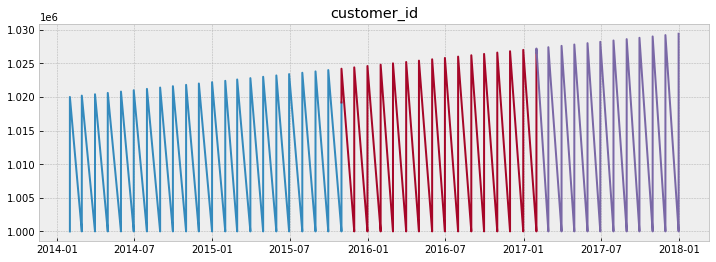

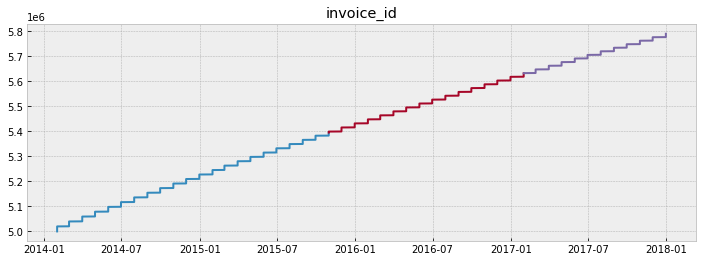

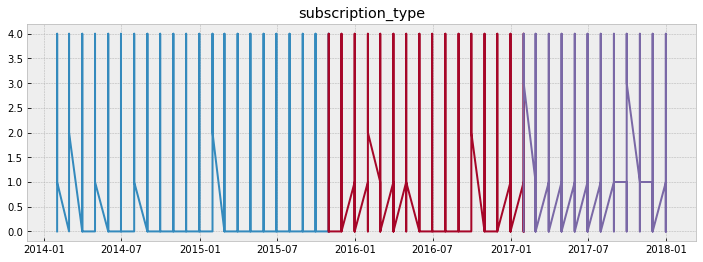

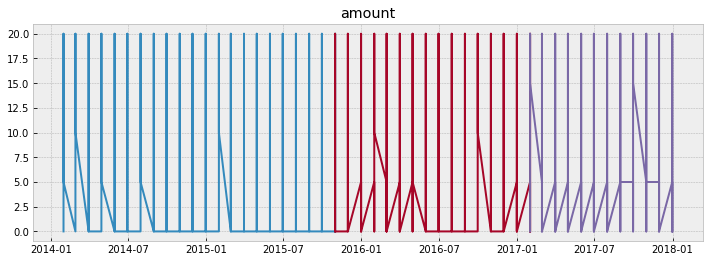

In [23]:
# plot the data points, color by train, validate, test

for col in train.columns:
    #set the fig size
    plt.figure(figsize = (12,4))
    #plot the train
    plt.plot(train[col])
    #plot the validate
    plt.plot(validate[col])
    #plot the test
    plt.plot(test[col])
    #add a title
    plt.title(col)
    plt.show()